#### 데이터 출처
    - 통계청,「인구동향조사」, 2021, 2022.12.22, 시군구/성/연령(5세)별 주민등록연앙인구 
    - https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040M5&conn_path=I2
    
    
    - 데이터 정리
        - 인구감소지역
            - danger_loc / 인구감소지역_성별_5세_인구수.csv
            - danger_loc_m / 인구감소지역_남성.csv
            - danger_loc_w / 인구감소지역_여성.csv
        
        - 관심지역
            -att_loc_m / 관심지역_남성.csv
            -att_loc_w / 관심지역_여성.csv

        - 안심지역
            - safe_loc / 안심지역_성_5세_인구.csv
            - safe_loc_m / 안심지역_남성.csv
            - safe_loc_w / 안심지역_여성.csv



In [692]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [693]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [694]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [9]:
def idx_col_pre(df,indexes=None,columns=None,indexing=None,idxname = None):
    # 필요없는 행 삭제
    if indexes==None:
        pass
    else:
        df.drop(indexes,axis=0,inplace=True)
    
    # 필요없는 열 삭제
    if columns==None:
        pass
    else:
        df.drop(columns,axis=1,inplace=True)

    # 인덱스 지정 후 해당 컬럼 삭제, 이름 변경도 가능.
    if indexing==None:
        pass
    else:
        if idxname == None:
            df.index = df[indexing]
            df.drop(indexing,axis=1,inplace=True)
        else:
            df.rename(columns={indexing:idxname},inplace=True)
            df.index = df[idxname]
            df.drop(idxname,axis=1,inplace=True)

In [136]:
data_original = pd.read_csv("./data/시군구_성별_5세.csv")
data_original.head(3)
data_set = data_original

,행정구역(시군구)별,성별,연령별,항목,단위,2016 년,2017 년,2018 년,2019 년,2020 년,Unnamed: 10
0,부산광역시,남자,0 - 4세,주민등록연앙인구[명],명,68674.0,65795.5,61940.0,57790.5,52603.5,NaN
1,부산광역시,남자,5 - 9세,주민등록연앙인구[명],명,68581.5,69197.0,69043.0,69202.5,69384.5,NaN
2,부산광역시,남자,10 - 14세,주민등록연앙인구[명],명,72129.0,69394.5,68020.5,66575.0,66611.5,NaN


In [137]:
# 필요없는 행 삭제 및 컬럼 이름 변경
idx_col_pre(data_set,columns=["항목","단위","Unnamed: 10"])
data_set.rename(columns={"행정구역(시군구)별":"sigungu"},inplace=True)

- 광역시, 도 데이터 삭제

In [138]:
# 광역시 이름이 있는 지 확인
cities=data_set["sigungu"].unique()
remove_citise=[]
for city in cities:
    data = city
    if data.endswith("광역시") or data.endswith("도"):
        remove_citise.append(str(city))
remove_citise

['부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도']

In [139]:
data_set.shape

(10416, 8)

In [140]:
# 위에서 뽑은 삭제해야할 지역의 인덱스를 추출하여 이를 통해서 해당 지역을 데이터셋에서 삭제
remove_citise_idx = []
for city in remove_citise:
    index = data_set[data_set["sigungu"]==city].index
    remove_citise_idx.extend(index)
    
# 삭제 전
print(data_set.shape)

#삭제 후
data_set.drop(remove_citise_idx,axis=0,inplace=True)
print(data_set.shape)

(10416, 8)
(9828, 8)


- 42개의 행마다 지역이 바뀜, 0~100세 이상까지 성별당 21개씩 분포되어있음.
- 특정 연령을 추출하기 위해서는 수열을 사용하면 가능할 뜻.

### 인구감소지역과 안심지역 분리
    - 지역을 분리한 후 10세 단위로 연령분리 함수 생성

In [368]:
# 인구감소지역
danger_locations = ["동구", "서구", "영도구", "남구", "강화군", "옹진군", "가평군", "연천군", "고성군", "삼척시", "양구군", "양양군",
             "영월군", "정선군", "철원군", "태백시", "평창군", "홍천군", "화천군", "횡성군", "괴산군", "단양군", "보은군", "영동군",
             "옥천군", "제천시", "공주시", "금산군", "논산시", "보령시", "부여군", "서천군", "예산군", "청양군", "태안군", "고창군", 
             "김제시", "남원시", "무주군", "부안군", "순창군", "임실군", "장수군", "정읍시", "진안군", "강진군", "고흥군", "곡성군",
             "구례군", "담양군", "보성군", "신안군", "영광군", "영암군", "완도군", "장성군", "장흥군", "진도군", "함평군", "해남군", 
             "화순군", "고령군", "군위군", "문경시", "봉화군", "상주시", "성주군", "안동시", "영덕군", "영양군", "영주시", "영천시", 
             "울릉군", "울진군", "의성군", "청도군", "청송군", "거창군", "남해군", "밀양시", "산청군", "의령군", "창녕군", "하동군", 
             "함안군", "함양군", "합천군"]

In [49]:
#인구 감소지역 인덱스 찾기
danger_loc_idx = []
for loc in danger_locations:
    idx = data_set[data_set["sigungu"]==loc].index
    danger_loc_idx.extend(idx)
#danger_loc_idx
len(danger_loc_idx)/42

102.0

In [102]:
danger_loc = data_set.iloc[danger_loc_idx]
danger_loc["sigungu"].value_counts()

동구     252
남구     252
서구     210
고성군     84
장성군     42
      ... 
논산시     42
금산군     42
공주시     42
제천시     42
합천군     42
Name: sigungu, Length: 87, dtype: int64

In [93]:
# 맞는 지역확인
#danger_loc[danger_loc["sigungu"]=="동구"].to_csv("./data/1_동구.csv")
donggu = danger_loc[danger_loc["sigungu"]=="동구"].index

In [123]:
def clear_city(df, fake_index, real):
    # 잘못 선정된 지역의 인덱스를 추출할 때 인트인덱스객체에 담겨오기 때문에 remove를 할 수 없다.
    # 그러기에 list로 변환한 후에 만든다.
    fake_index = list(fake_index)
    
    if type(real) == list:
        for r in real:
            for idx in r:
                if idx in fake_index:
                    fake_index.remove(idx)
    else:
        for idx in real:
            if idx in fake_index:
                fake_index.remove(idx)
            
    df.drop(fake_index,axis=0,inplace=True)
    
    return df

In [103]:
# 진짜 인구감소지역, 부산 동구 인덱스
donggu_r = np.arange(126,168)
clear_city(danger_loc,donggu,donggu_r)
danger_loc["sigungu"].value_counts()

C:\Users\KangMinGu\AppData\Local\Temp\ipykernel_11348\3622910270.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(fake_index,axis=0,inplace=True)


,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
126,동구,남자,0 - 4세,1203.5,1127.5,1062.5,1038.5,1018.5
127,동구,남자,5 - 9세,1180.5,1160.5,1122.0,1114.0,1144.0
128,동구,남자,10 - 14세,1355.5,1247.5,1193.0,1132.5,1125.0
129,동구,남자,15 - 19세,2154.0,1979.5,1823.5,1693.0,1574.0
130,동구,남자,20 - 24세,2969.0,2793.5,2588.5,2441.5,2352.0
...,...,...,...,...,...,...,...,...
10411,합천군,여자,80 - 84세,2130.5,2230.0,2257.5,2274.0,2323.0
10412,합천군,여자,85 - 89세,945.5,1021.5,1130.0,1290.5,1405.0
10413,합천군,여자,90 - 94세,315.5,328.5,345.0,374.5,421.5
10414,합천군,여자,95 - 99세,62.0,78.5,97.0,105.5,98.5


남구     252
서구     210
고성군     84
동구      42
장성군     42
      ... 
논산시     42
금산군     42
공주시     42
제천시     42
합천군     42
Name: sigungu, Length: 87, dtype: int64

In [104]:
danger_loc[danger_loc["sigungu"]=="남구"].to_csv("./data/1_남구.csv")
namgu = danger_loc[danger_loc["sigungu"]=="남구"].index

In [105]:
namgu_r = np.arange(882,924)
clear_city(danger_loc,namgu,namgu_r)
danger_loc["sigungu"].value_counts()

C:\Users\KangMinGu\AppData\Local\Temp\ipykernel_11348\3622910270.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(fake_index,axis=0,inplace=True)


,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
126,동구,남자,0 - 4세,1203.5,1127.5,1062.5,1038.5,1018.5
127,동구,남자,5 - 9세,1180.5,1160.5,1122.0,1114.0,1144.0
128,동구,남자,10 - 14세,1355.5,1247.5,1193.0,1132.5,1125.0
129,동구,남자,15 - 19세,2154.0,1979.5,1823.5,1693.0,1574.0
130,동구,남자,20 - 24세,2969.0,2793.5,2588.5,2441.5,2352.0
...,...,...,...,...,...,...,...,...
10411,합천군,여자,80 - 84세,2130.5,2230.0,2257.5,2274.0,2323.0
10412,합천군,여자,85 - 89세,945.5,1021.5,1130.0,1290.5,1405.0
10413,합천군,여자,90 - 94세,315.5,328.5,345.0,374.5,421.5
10414,합천군,여자,95 - 99세,62.0,78.5,97.0,105.5,98.5


서구     210
고성군     84
장성군     42
문경시     42
군위군     42
      ... 
논산시     42
금산군     42
공주시     42
제천시     42
합천군     42
Name: sigungu, Length: 87, dtype: int64

In [108]:
danger_loc[danger_loc["sigungu"]=="서구"].to_csv("./data/1_서구.csv")
seogu = danger_loc[danger_loc["sigungu"]=="서구"].index

In [124]:
seogu_r_1 = np.arange(840,882)
seogu_r_2 = np.arange(84,126)
clear_city(danger_loc,seogu,[seogu_r_1,seogu_r_2])
danger_loc["sigungu"].value_counts()

C:\Users\KangMinGu\AppData\Local\Temp\ipykernel_11348\3262853192.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(fake_index,axis=0,inplace=True)


,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
126,동구,남자,0 - 4세,1203.5,1127.5,1062.5,1038.5,1018.5
127,동구,남자,5 - 9세,1180.5,1160.5,1122.0,1114.0,1144.0
128,동구,남자,10 - 14세,1355.5,1247.5,1193.0,1132.5,1125.0
129,동구,남자,15 - 19세,2154.0,1979.5,1823.5,1693.0,1574.0
130,동구,남자,20 - 24세,2969.0,2793.5,2588.5,2441.5,2352.0
...,...,...,...,...,...,...,...,...
10411,합천군,여자,80 - 84세,2130.5,2230.0,2257.5,2274.0,2323.0
10412,합천군,여자,85 - 89세,945.5,1021.5,1130.0,1290.5,1405.0
10413,합천군,여자,90 - 94세,315.5,328.5,345.0,374.5,421.5
10414,합천군,여자,95 - 99세,62.0,78.5,97.0,105.5,98.5


서구     84
고성군    84
장성군    42
문경시    42
군위군    42
       ..
논산시    42
금산군    42
공주시    42
제천시    42
합천군    42
Name: sigungu, Length: 87, dtype: int64

#### 중복 지역이 부산, 대구의 서구 그리고 강원도, 경남의 고성군이 있기에, 총 89개 지역이지만 길이가 87이 나오고 중복 지역 2개를 더해주면 총 89개의 인구감소지역이 들어간 것을 확인할 수 있다.

In [143]:
# 위험지역을 제외한 안심지역 추출
safe_loc = data_set.drop(danger_loc.index,axis=0)

In [222]:
safe_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6090 entries, 0 to 6089
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sigungu  6090 non-null   object 
 1   성별       6090 non-null   object 
 2   연령별      6090 non-null   object 
 3   2016 년   6048 non-null   float64
 4   2017 년   6048 non-null   float64
 5   2018 년   6048 non-null   float64
 6   2019 년   6048 non-null   float64
 7   2020 년   6048 non-null   float64
dtypes: float64(5), object(3)
memory usage: 380.8+ KB


In [145]:
#safe_loc.to_csv("./data/안심지역_성별_5세_인구수.csv")
#danger_loc.to_csv("./data/인구감소지역_성별_5세_인구수.csv")

In [6]:
safe_loc = pd.read_csv("./data/안심지역_성별_5세_인구수.csv")
danger_loc = pd.read_csv("./data/인구감소지역_성별_5세_인구수.csv")

- 감소지역과 안심지역의 남녀 인구수 평균을 산출,
- 100세 이상의 경우 0의 데이터가 많으므로 

In [8]:
danger_loc.drop("Unnamed: 0",axis=1,inplace=True)

In [84]:
danger_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738 entries, 0 to 3737
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sigungu  3738 non-null   object 
 1   성별       3738 non-null   object 
 2   연령별      3738 non-null   object 
 3   2016 년   3738 non-null   float64
 4   2017 년   3738 non-null   float64
 5   2018 년   3738 non-null   float64
 6   2019 년   3738 non-null   float64
 7   2020 년   3738 non-null   float64
 8   16_17    3724 non-null   float64
dtypes: float64(6), object(3)
memory usage: 263.0+ KB


In [553]:
danger_loc_m = danger_loc[danger_loc["성별"]=="남자"]
danger_loc_w = danger_loc[danger_loc["성별"]=="여자"]

In [554]:
safe_loc_m = safe_loc[safe_loc["성별"]=="남자"]
safe_loc_w = safe_loc[safe_loc["성별"]=="여자"]

In [555]:
#danger_loc_m.to_csv("./data/인구감소지역_남성.csv")
#danger_loc_w.to_csv("./data/인구감소지역_여성.csv")

In [556]:
danger_loc_m = pd.read_csv("./data/인구감소지역_남성.csv")
danger_loc_w =pd.read_csv("./data/인구감소지역_여성.csv")
safe_loc_m = pd.read_csv("./data/안심지역_남성.csv")
safe_loc_w =pd.read_csv("./data/안심지역_여성.csv")

In [558]:
danger_loc_m.drop("Unnamed: 0",axis=1,inplace=True)
danger_loc_w.drop("Unnamed: 0",axis=1,inplace=True)
safe_loc_m.drop("Unnamed: 0",axis=1,inplace=True)
safe_loc_w.drop("Unnamed: 0",axis=1,inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [560]:
# 남구, 미추홀구 데이터 잡기
nam = np.arange(358,379)
mi = np.arange(379,400)
d2016 = safe_loc_m.iloc[nam]["2016 년"].values
safe_loc_m.loc[mi,"2016 년"] = d2016
d2017 = safe_loc_m.iloc[nam]["2017 년"].values
safe_loc_m.loc[mi,"2017 년"] = d2017
safe_loc_m.loc[mi]

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
379,미추홀구,남자,5 - 9세,8366.5,8577.0,8477.0,8256.5,7986.5
380,미추홀구,남자,10 - 14세,8205.0,8121.5,8045.0,7864.5,7753.0
381,미추홀구,남자,15 - 19세,11701.0,11110.0,10458.5,9782.0,8948.5
382,미추홀구,남자,20 - 24세,15060.0,15089.5,14773.5,14211.0,13742.0
383,미추홀구,남자,25 - 29세,14897.0,15623.0,16199.0,16413.0,16430.0
384,미추홀구,남자,30 - 34세,16114.0,15592.5,14880.0,14260.0,13968.5
385,미추홀구,남자,35 - 39세,17130.0,17997.0,18142.0,17386.0,16170.5
386,미추홀구,남자,40 - 44세,17337.0,16925.0,16278.5,15811.0,15762.5
387,미추홀구,남자,45 - 49세,17125.0,17929.0,18185.0,17893.5,17405.5
388,미추홀구,남자,50 - 54세,16807.5,16593.5,16432.5,16481.5,16548.0


In [561]:
# 남구, 미추홀구 데이터 잡기
nam = np.arange(358,379)
mi = np.arange(379,400)
d2016 = safe_loc_w.iloc[nam]["2016 년"].values
safe_loc_w.loc[mi,"2016 년"] = d2016
d2017 = safe_loc_w.iloc[nam]["2017 년"].values
safe_loc_w.loc[mi,"2017 년"] = d2017
safe_loc_w.loc[mi]

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
379,미추홀구,여자,5 - 9세,7901.5,8097.0,7983.5,7809.5,7596.0
380,미추홀구,여자,10 - 14세,7694.5,7567.5,7484.0,7326.0,7246.0
381,미추홀구,여자,15 - 19세,10791.0,10349.5,9709.0,9078.0,8406.0
382,미추홀구,여자,20 - 24세,13512.5,13627.0,13407.5,12974.0,12597.0
383,미추홀구,여자,25 - 29세,12760.5,13438.0,13857.0,14033.0,14219.5
384,미추홀구,여자,30 - 34세,14360.0,13805.0,13034.0,12322.0,11879.0
385,미추홀구,여자,35 - 39세,14999.5,15688.0,15808.5,15195.5,14170.5
386,미추홀구,여자,40 - 44세,15380.5,15052.0,14461.0,14008.5,13899.5
387,미추홀구,여자,45 - 49세,16424.5,16937.5,16903.5,16533.5,15894.5
388,미추홀구,여자,50 - 54세,16792.0,16542.5,16512.0,16415.5,16207.5


In [563]:
# 남구, 미추홀구 데이터 잡기
safe_loc_m.drop(nam,axis=0,inplace=True)
safe_loc_w.drop(nam,axis=0,inplace=True)

In [564]:
safe_loc_m.to_csv("./data/안심지역_남성.csv")
safe_loc_w.to_csv("./data/안심지역_여성.csv")

- 연령대별 변화 중 고령의 경우 사망인지, 이동인지 구별하기 힘듬

- 남녀 성별을 기준으로 데이터를 나눈 후 연도별로 각 지역의 남자의 합과 여성의 합을 산출

#### 관심지역 분리

In [372]:
# 대전 동구, 인천 동구, 광주 동구 / 부산 중구, 대전 중구,
attention_locations = ["동구","중구","금정구","통영시","강릉시","동해시","경주시","사천시","김천시","대덕구","인제군","익산시","동두천시","속초시","포천시"]

In [373]:
attention_loc_idx = []
for loc in attention_locations:
    idx = safe_loc_m[safe_loc_m["sigungu"]==loc].index
    attention_loc_idx.extend(idx)
len(attention_loc_idx)/21

23.0

In [377]:
att_loc_m = safe_loc_m.iloc[attention_loc_idx]
#att_loc_m.to_csv("./data/수정해야하는.csv")

In [378]:
att_loc_w = safe_loc_w.iloc[attention_loc_idx]
#att_loc_w.to_csv("./data/수정해야하는2.csv")

294 314 >> 대구 동구
819 839 >> 울산 동구
273,293 >> 대구 중구
399,419 >> 인천 중구
777,797 >> 울산 중구

In [381]:
def clear_index_data(df, index):
    for idx in index:
        range = np.arange(idx[0], idx[1]+1)
        df.drop(range,axis=0,inplace=True)

In [387]:
clear_index_data(att_loc_m,[[294,314],[819,839],[273,293],[399,419],[777,797]])
clear_index_data(att_loc_w,[[294,314],[819,839],[273,293],[399,419],[777,797]])

C:\Users\KangMinGu\AppData\Local\Temp\ipykernel_21448\2539902293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(range,axis=0,inplace=True)
C:\Users\KangMinGu\AppData\Local\Temp\ipykernel_21448\2539902293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(range,axis=0,inplace=True)
C:\Users\KangMinGu\AppData\Local\Temp\ipykernel_21448\2539902293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(range,axis

In [566]:
#att_loc_m.to_csv("./data/관심지역_남성.csv")
#att_loc_w.to_csv("./data/관심지역_여성.csv")

In [388]:
att_loc_m["sigungu"].value_counts()
att_loc_w["sigungu"].value_counts()

동구      63
중구      42
금정구     21
통영시     21
강릉시     21
동해시     21
경주시     21
사천시     21
김천시     21
대덕구     21
인제군     21
익산시     21
동두천시    21
속초시     21
포천시     21
Name: sigungu, dtype: int64

동구      63
중구      42
금정구     21
통영시     21
강릉시     21
동해시     21
경주시     21
사천시     21
김천시     21
대덕구     21
인제군     21
익산시     21
동두천시    21
속초시     21
포천시     21
Name: sigungu, dtype: int64

<hr>

In [567]:
dan_loc_pop_m_2016 = []
dan_loc_pop_m_2017 = []
dan_loc_pop_m_2018 = []
dan_loc_pop_m_2019 = []
dan_loc_pop_m_2020 = []
start = 0
end = 20
while True:
    if len(dan_loc_pop_m_2020)==89:
        break
    else:
        years = ["2016 년","2017 년","2018 년","2019 년","2020 년"]
        loc_pop = danger_loc_m[years]
        
        range = np.arange(start,end+1) 
        loc_pop = loc_pop.iloc[range].sum(numeric_only=True) # 해당 지역 해당 연도 남성 전체 인구 산출
        
        dan_loc_pop_m_2016.append(loc_pop["2016 년"])
        dan_loc_pop_m_2017.append(loc_pop["2017 년"])
        dan_loc_pop_m_2018.append(loc_pop["2018 년"])
        dan_loc_pop_m_2019.append(loc_pop["2019 년"])
        dan_loc_pop_m_2020.append(loc_pop["2020 년"])
        
        start += 21
        end += 21

In [568]:
dan_loc_pop_w_2016 = []
dan_loc_pop_w_2017 = []
dan_loc_pop_w_2018 = []
dan_loc_pop_w_2019 = []
dan_loc_pop_w_2020 = []
start = 0
end = 20
while True:
    if len(dan_loc_pop_w_2020)==89: # 89개 지역
        break
    else:
        years = ["2016 년","2017 년","2018 년","2019 년","2020 년"]
        loc_pop = danger_loc_w[years]
        
        range = np.arange(start,end+1)
        loc_pop = loc_pop.iloc[range].sum(numeric_only=True) # 해당 지역 해당 연도 여성 전체 인구 산출
        
        dan_loc_pop_w_2016.append(loc_pop["2016 년"])
        dan_loc_pop_w_2017.append(loc_pop["2017 년"])
        dan_loc_pop_w_2018.append(loc_pop["2018 년"])
        dan_loc_pop_w_2019.append(loc_pop["2019 년"])
        dan_loc_pop_w_2020.append(loc_pop["2020 년"])
        
        start += 21 # 지역마다 21개의 데이터가 있기 때문에 계속 옮기는 것
        end += 21

In [569]:
dan_loc_m_pop = [dan_loc_pop_m_2016, dan_loc_pop_m_2017,dan_loc_pop_m_2018, dan_loc_pop_m_2019, dan_loc_pop_m_2020]
dan_loc_w_pop = [dan_loc_pop_w_2016, dan_loc_pop_w_2017,dan_loc_pop_w_2018, dan_loc_pop_w_2019, dan_loc_pop_w_2020]

In [570]:
dan_loc_pop_m_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,89)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (dan_loc_m_pop[i+1][j] - dan_loc_m_pop[i][j]) / dan_loc_m_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    dan_loc_pop_m_change.append(data_zip)

In [571]:
dan_loc_pop_w_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,89)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (dan_loc_w_pop[i+1][j] - dan_loc_w_pop[i][j]) / dan_loc_w_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    dan_loc_pop_w_change.append(data_zip)

In [572]:
len(dan_loc_pop_m_change)
len(dan_loc_pop_m_change[0])
len(dan_loc_pop_w_change)
len(dan_loc_pop_w_change[0])

4

89

4

89

In [573]:
dan_loc_df = pd.DataFrame({"남자(16_17)":dan_loc_pop_m_change[0],
                           "남자(17_18)":dan_loc_pop_m_change[1],
                           "남자(18_19)":dan_loc_pop_m_change[2],
                           "남자(19_20)":dan_loc_pop_m_change[3],
                           "여자(16_17)":dan_loc_pop_w_change[0],
                           "여자(17_18)":dan_loc_pop_w_change[1],
                           "여자(18_19)":dan_loc_pop_w_change[2],
                           "여자(19_20)":dan_loc_pop_w_change[3],
                          })

In [574]:
dan_pop_ch = pd.DataFrame(dan_loc_df.mean())
dan_pop_ch.reset_index()

,index,0
0,남자(16_17),-0.784499
1,남자(17_18),-1.086091
2,남자(18_19),-1.355182
3,남자(19_20),-1.419050
4,여자(16_17),-0.856724
5,여자(17_18),-1.147689
6,여자(18_19),-1.500930
7,여자(19_20),-1.659266


<AxesSubplot:>

<AxesSubplot:>

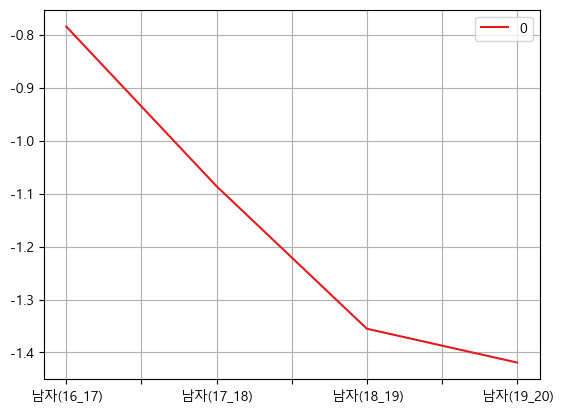

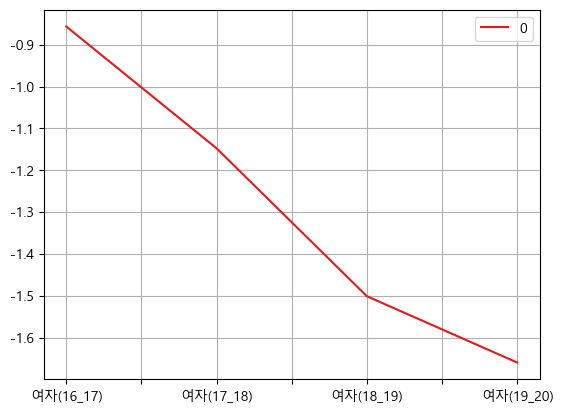

In [575]:
dan_pop_ch.iloc[[0,1,2,3]].plot()
plt.grid()
dan_pop_ch.iloc[[4,5,6,7]].plot()
plt.grid()

In [577]:
loc_pop

,2016 년,2017 년,2018 년,2019 년,2020 년
0,6892.5,6534.0,6065.5,5534.0,5003.0
1,6567.0,6488.0,6325.0,6171.5,6072.0
2,6731.5,6358.0,6137.0,5894.5,5856.0
3,10066.0,9247.0,8477.0,7870.0,7198.0
4,13776.0,13274.0,12526.0,11842.5,11470.0
...,...,...,...,...,...
2662,865.5,972.0,1080.0,1185.0,1282.0
2663,295.5,325.0,369.0,414.5,473.0
2664,68.0,74.5,83.5,102.0,108.5
2665,8.5,11.5,14.5,14.5,15.0


In [579]:
safe_loc_pop_m_2016 = []
safe_loc_pop_m_2017 = []
safe_loc_pop_m_2018 = []
safe_loc_pop_m_2019 = []
safe_loc_pop_m_2020 = []
start = 0
end = 20
while True:
    if len(safe_loc_pop_m_2020)==126:
        break
    else:
        years = ["2016 년","2017 년","2018 년","2019 년","2020 년"]
        loc_pop = safe_loc_m[years]
        
        range = np.arange(start,end+1) 
        loc_pop = loc_pop.iloc[range].sum(numeric_only=True) # 해당 지역 해당 연도 남성 전체 인구 산출
        
        safe_loc_pop_m_2016.append(loc_pop["2016 년"])
        safe_loc_pop_m_2017.append(loc_pop["2017 년"])
        safe_loc_pop_m_2018.append(loc_pop["2018 년"])
        safe_loc_pop_m_2019.append(loc_pop["2019 년"])
        safe_loc_pop_m_2020.append(loc_pop["2020 년"])
        
        start += 21
        end += 21

In [581]:
safe_loc_pop_w_2016 = []
safe_loc_pop_w_2017 = []
safe_loc_pop_w_2018 = []
safe_loc_pop_w_2019 = []
safe_loc_pop_w_2020 = []
start = 0
end = 20
while True:
    if len(safe_loc_pop_w_2020)==126:
        break
    else:
        years = ["2016 년","2017 년","2018 년","2019 년","2020 년"]
        loc_pop = safe_loc_w[years]
        
        range = np.arange(start,end+1)
        loc_pop = loc_pop.iloc[range].sum(numeric_only=True) # 해당 지역 해당 연도 여성 전체 인구 산출
        
        safe_loc_pop_w_2016.append(loc_pop["2016 년"])
        safe_loc_pop_w_2017.append(loc_pop["2017 년"])
        safe_loc_pop_w_2018.append(loc_pop["2018 년"])
        safe_loc_pop_w_2019.append(loc_pop["2019 년"])
        safe_loc_pop_w_2020.append(loc_pop["2020 년"])
        
        start += 21
        end += 21

In [582]:
safe_loc_m_pop = [safe_loc_pop_m_2016, safe_loc_pop_m_2017,safe_loc_pop_m_2018, safe_loc_pop_m_2019, safe_loc_pop_m_2020]
safe_loc_w_pop = [safe_loc_pop_w_2016, safe_loc_pop_w_2017,safe_loc_pop_w_2018, safe_loc_pop_w_2019, safe_loc_pop_w_2020]

In [584]:
safe_loc_m_pop_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,126)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (safe_loc_m_pop[i+1][j] - safe_loc_m_pop[i][j]) / safe_loc_m_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    safe_loc_m_pop_change.append(data_zip)

In [585]:
safe_loc_w_pop_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,126)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (safe_loc_w_pop[i+1][j] - safe_loc_w_pop[i][j]) / safe_loc_w_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    safe_loc_w_pop_change.append(data_zip)

In [586]:
safe_pop_ch = pd.DataFrame({"남자(16_17)":safe_loc_w_pop_change[0],
                           "남자(17_18)":safe_loc_w_pop_change[1],
                           "남자(18_19)":safe_loc_w_pop_change[2],
                           "남자(19_20)":safe_loc_w_pop_change[3],
                           "여자(16_17)":safe_loc_w_pop_change[0],
                           "여자(17_18)":safe_loc_w_pop_change[1],
                           "여자(18_19)":safe_loc_w_pop_change[2],
                           "여자(19_20)":safe_loc_w_pop_change[3],
                          })

In [587]:
safe_pop_ch = pd.DataFrame(safe_pop_ch.mean())
safe_pop_ch

,0
남자(16_17),0.813003
남자(17_18),0.554384
남자(18_19),0.388801
남자(19_20),0.304259
여자(16_17),0.813003
여자(17_18),0.554384
여자(18_19),0.388801
여자(19_20),0.304259


<AxesSubplot:>

<AxesSubplot:>

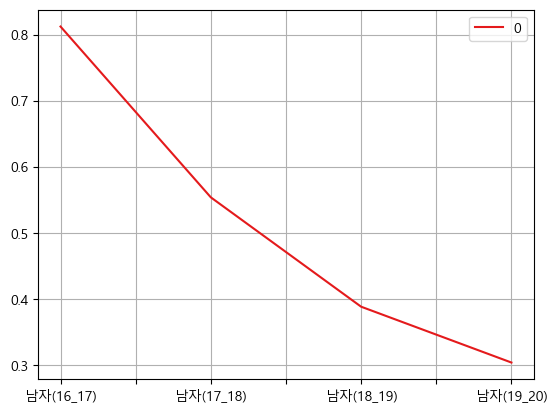

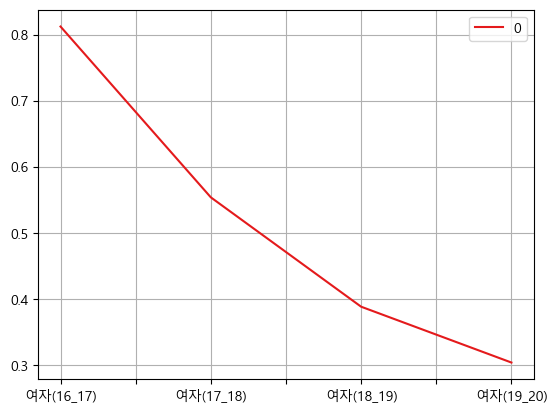

In [588]:
safe_pop_ch.iloc[[0,1,2,3]].plot()
plt.grid()
safe_pop_ch.iloc[[4,5,6,7]].plot()
plt.grid()

In [589]:
safe_pop_ch
dan_pop_ch

,0
남자(16_17),0.813003
남자(17_18),0.554384
남자(18_19),0.388801
남자(19_20),0.304259
여자(16_17),0.813003
여자(17_18),0.554384
여자(18_19),0.388801
여자(19_20),0.304259


,0
남자(16_17),-0.784499
남자(17_18),-1.086091
남자(18_19),-1.355182
남자(19_20),-1.419050
여자(16_17),-0.856724
여자(17_18),-1.147689
여자(18_19),-1.500930
여자(19_20),-1.659266


In [590]:
att_loc_m_pop_2016 = []
att_loc_m_pop_2017 = []
att_loc_m_pop_2018 = []
att_loc_m_pop_2019 = []
att_loc_m_pop_2020 = []
start = 0
end = 20
while True:
    if len(att_loc_m_pop_2020)==18:
        break
    else:
        years = ["2016 년","2017 년","2018 년","2019 년","2020 년"]
        loc_pop = att_loc_m[years]
        
        range = np.arange(start,end+1) 
        loc_pop = loc_pop.iloc[range].sum() # 해당 지역 해당 연도 남성 전체 인구 산출
        
        att_loc_m_pop_2016.append(loc_pop["2016 년"])
        att_loc_m_pop_2017.append(loc_pop["2017 년"])
        att_loc_m_pop_2018.append(loc_pop["2018 년"])
        att_loc_m_pop_2019.append(loc_pop["2019 년"])
        att_loc_m_pop_2020.append(loc_pop["2020 년"])
        
        start += 21
        end += 21

In [591]:
len(att_loc_m_pop_2016)

18

In [592]:
att_loc_w_pop_2016 = []
att_loc_w_pop_2017 = []
att_loc_w_pop_2018 = []
att_loc_w_pop_2019 = []
att_loc_w_pop_2020 = []
start = 0
end = 20
while True:
    if len(att_loc_w_pop_2020)==18:
        break
    else:
        years = ["2016 년","2017 년","2018 년","2019 년","2020 년"]
        loc_pop = att_loc_w[years]
        
        range = np.arange(start,end+1) 
        loc_pop = loc_pop.iloc[range].sum() # 해당 지역 해당 연도 남성 전체 인구 산출
        
        att_loc_w_pop_2016.append(loc_pop["2016 년"])
        att_loc_w_pop_2017.append(loc_pop["2017 년"])
        att_loc_w_pop_2018.append(loc_pop["2018 년"])
        att_loc_w_pop_2019.append(loc_pop["2019 년"])
        att_loc_w_pop_2020.append(loc_pop["2020 년"])
        
        start += 21
        end += 21

In [593]:
att_loc_m_pop = [att_loc_m_pop_2016, att_loc_m_pop_2017,att_loc_m_pop_2018, att_loc_m_pop_2019, att_loc_m_pop_2020]
att_loc_w_pop = [att_loc_w_pop_2016, att_loc_w_pop_2017,att_loc_w_pop_2018, att_loc_w_pop_2019, att_loc_w_pop_2020]

In [594]:
att_loc_m_pop_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,18)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (att_loc_m_pop[i+1][j] - att_loc_m_pop[i][j]) / att_loc_m_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    att_loc_m_pop_change.append(data_zip)

In [595]:
att_loc_w_pop_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,18)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (att_loc_w_pop[i+1][j] - att_loc_w_pop[i][j]) / att_loc_w_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    att_loc_w_pop_change.append(data_zip)

In [596]:
len(att_loc_m_pop_change)
len(att_loc_m_pop_change[0])
len(att_loc_w_pop_change)
len(att_loc_w_pop_change[0])

4

18

4

18

In [597]:
att_loc_df = pd.DataFrame({"남자(16_17)":att_loc_m_pop_change[0],
                           "남자(17_18)":att_loc_m_pop_change[1],
                           "남자(18_19)":att_loc_m_pop_change[2],
                           "남자(19_20)":att_loc_m_pop_change[3],
                           "여자(16_17)":att_loc_w_pop_change[0],
                           "여자(17_18)":att_loc_w_pop_change[1],
                           "여자(18_19)":att_loc_w_pop_change[2],
                           "여자(19_20)":att_loc_w_pop_change[3],
                          })

In [598]:
att_pop_ch = pd.DataFrame(att_loc_df.mean())
att_pop_ch

,0
남자(16_17),-0.901926
남자(17_18),-1.193931
남자(18_19),-1.266587
남자(19_20),-0.850029
여자(16_17),-0.873719
여자(17_18),-1.174997
여자(18_19),-1.259330
여자(19_20),-0.826468


In [599]:
dan_pop_ch = pd.DataFrame(dan_pop_ch)

In [602]:
dan_pop_ch.rename(columns ={0:"감소_인구변화율"},inplace=True)
att_pop_ch.rename(columns ={0:"관심_인구변화율"},inplace=True)
safe_pop_ch.rename(columns ={0:"안심_인구변화율"},inplace=True)

In [603]:
fin_data = pd.DataFrame({"감소_인구변화율":dan_pop_ch["감소_인구변화율"],
                         "관심_인구변화율":att_pop_ch["관심_인구변화율"],
                         "안심_인구변화율":safe_pop_ch["안심_인구변화율"]
                        })

In [604]:
fin_data.columns=["감소지역","관심지역","안심지역"]
fin_data

,감소지역,관심지역,안심지역
남자(16_17),-0.784499,-0.901926,0.813003
남자(17_18),-1.086091,-1.193931,0.554384
남자(18_19),-1.355182,-1.266587,0.388801
남자(19_20),-1.419050,-0.850029,0.304259
여자(16_17),-0.856724,-0.873719,0.813003
여자(17_18),-1.147689,-1.174997,0.554384
여자(18_19),-1.500930,-1.259330,0.388801
여자(19_20),-1.659266,-0.826468,0.304259


In [605]:
fin_data_m = fin_data.loc[["남자(16_17)","남자(17_18)","남자(18_19)","남자(19_20)"]]
fin_data_w = fin_data.loc[["여자(16_17)","여자(17_18)","여자(18_19)","여자(19_20)"]]

In [606]:
fin_data_m.index = ["2016 - 2017","2017 - 2018","2018 - 2019","2019 - 2020"]
fin_data_w.index = ["2016 - 2017","2017 - 2018","2018 - 2019","2019 - 2020"]

In [607]:
fin_data_m
fin_data_w

,감소지역,관심지역,안심지역
2016 - 2017,-0.784499,-0.901926,0.813003
2017 - 2018,-1.086091,-1.193931,0.554384
2018 - 2019,-1.355182,-1.266587,0.388801
2019 - 2020,-1.419050,-0.850029,0.304259


,감소지역,관심지역,안심지역
2016 - 2017,-0.856724,-0.873719,0.813003
2017 - 2018,-1.147689,-1.174997,0.554384
2018 - 2019,-1.500930,-1.259330,0.388801
2019 - 2020,-1.659266,-0.826468,0.304259


<AxesSubplot:>

Text(0.5, 1.0, '남성인구변화율')

Text(0.5, 0, '기준년도')

Text(0, 0.5, '인구변화율')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2016 - 2017'),
  Text(1, 0, '2017 - 2018'),
  Text(2, 0, '2018 - 2019'),
  Text(3, 0, '2019 - 2020')])

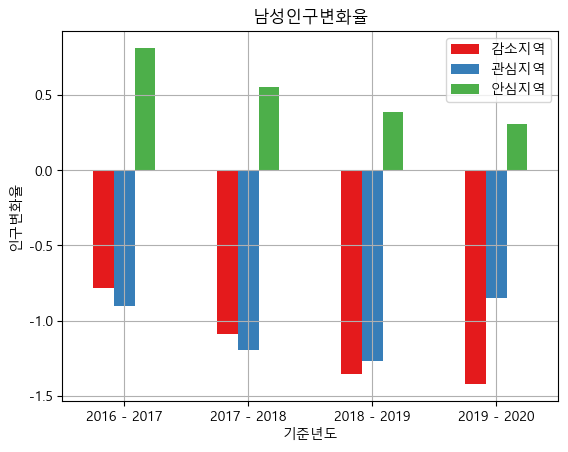

In [713]:
fin_data_m.plot(kind="bar",color = sns.set_palette('Set1'))
plt.grid()
plt.title("남성인구변화율")
plt.xlabel("기준년도")
plt.ylabel("인구변화율")
plt.xticks(rotation=0)
plt.savefig('output/집단별_남성인구변화율.png',bbox_inches="tight")

<AxesSubplot:>

Text(0.5, 1.0, '여성인구변화율')

Text(0.5, 0, '기준년도')

Text(0, 0.5, '인구변화율')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2016 - 2017'),
  Text(1, 0, '2017 - 2018'),
  Text(2, 0, '2018 - 2019'),
  Text(3, 0, '2019 - 2020')])

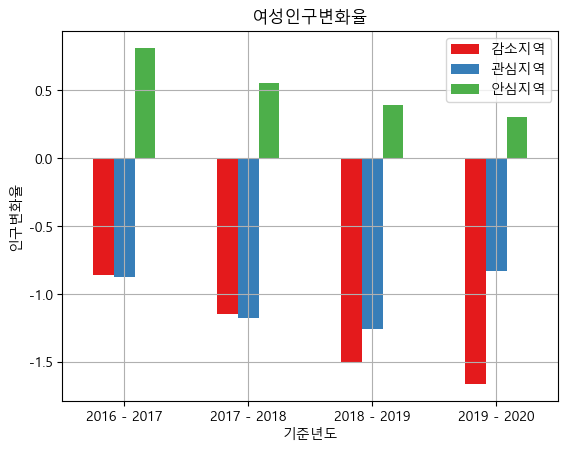

In [714]:
fin_data_w.plot(kind="bar",color = sns.set_palette('Set1'))
plt.grid()
plt.title("여성인구변화율")
plt.xlabel("기준년도")
plt.ylabel("인구변화율")
plt.xticks(rotation=0)
plt.savefig('output/집단별_여성인구변화율.png',bbox_inches="tight")

In [ ]:
att_loc_w_pop_change = []
i_idx = np.arange(0,4)
j_idx = np.arange(0,18)
for i in i_idx:
    data_zip = []
    for j in j_idx:
        data = (att_loc_w_pop[i+1][j] - att_loc_w_pop[i][j]) / att_loc_w_pop[i][j] * 100 # 연도별 각지역의 남자 인구수 변화율 계산
        data_zip.append(data)
    att_loc_w_pop_change.append(data_zip)
    
def vari_pop(df):
    data_list

In [524]:
safe_loc[safe_loc["sigungu"]=="속초시"]

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
3906,속초시,남자,0 - 4세,1551.0,1465.0,1398.0,1358.0,1311.0
3907,속초시,남자,5 - 9세,1706.0,1696.0,1666.5,1662.5,1679.5
3908,속초시,남자,10 - 14세,2064.5,1938.0,1852.5,1761.5,1742.5
3909,속초시,남자,15 - 19세,2748.5,2622.0,2487.0,2362.5,2195.5
3910,속초시,남자,20 - 24세,2793.5,2771.5,2729.0,2667.0,2618.5
3911,속초시,남자,25 - 29세,2107.0,2245.0,2277.0,2299.5,2413.0
3912,속초시,남자,30 - 34세,2355.0,2229.0,2161.0,2141.0,2195.0
3913,속초시,남자,35 - 39세,2640.0,2703.0,2750.5,2736.5,2682.0
3914,속초시,남자,40 - 44세,3172.0,3027.5,2892.5,2752.5,2751.0
3915,속초시,남자,45 - 49세,3742.5,3738.0,3706.0,3566.0,3409.0


In [525]:
attention_locations

['동구',
 '중구',
 '금정구',
 '통영시',
 '강릉시',
 '동해시',
 '경주시',
 '사천시',
 '김천시',
 '대덕구',
 '인제군',
 '익산시',
 '동두천시',
 '속초시',
 '포천시']

In [527]:
safe_loc.to_csv("./data/1_안심지역.csv")

### 대전 동구, 인천 동구, 광주 동구, 부산 중구, 대전 중구를 찾아서 제거해야함

In [529]:
attention_location = [
 '금정구',
 '통영시',
 '강릉시',
 '동해시',
 '경주시',
 '사천시',
 '김천시',
 '대덕구',
 '인제군',
 '익산시',
 '동두천시',
 '속초시',
 '포천시']

In [530]:
att_index =[]
for loc in attention_location:
    data = safe_loc[safe_loc["sigungu"]==loc].index
    att_index.extend(data)

In [531]:
# 중복지역을 제외한 지역의 인덱스
att_index

[294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 5628,
 5629,
 5630,
 5631,
 5632,
 5633,
 5634,
 5635,
 5636,
 5637,
 5638,
 5639,
 5640,
 5641,
 5642,
 5643,
 5644,
 5645,
 5646,
 5647,
 5648,
 5649,
 5650,
 5651,
 5652,
 5653,
 5654,
 5655,
 5656,
 5657,
 5658,
 5659,
 5660,
 5661,
 5662,
 5663,
 5664,
 5665,
 5666,
 5667,
 5668,
 5669,
 3822,
 3823,
 3824,
 3825,
 3826,
 3827,
 3828,
 3829,
 3830,
 3831,
 3832,
 3833,
 3834,
 3835,
 3836,
 3837,
 3838,
 3839,
 3840,
 3841,
 3842,
 3843,
 3844,
 3845,
 3846,
 3847,
 3848,
 3849,
 3850,
 3851,
 3852,
 3853,
 3854,
 3855,
 3856,
 3857,
 3858,
 3859,
 3860,
 3861,
 3862,
 3863,
 3864,
 3865,
 3866,
 3867,
 3868,
 3869,
 3870,
 3871,
 3872,
 3873,
 3874,
 3875,
 3876,
 3877,
 3878,
 3879,
 3880,
 3881,
 3882,
 3883,
 3884,
 3885,
 3886,

In [532]:
safe_loc.drop(att_index,axis=0)

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
0,중구,남자,0 - 4세,573.0,508.5,453.0,391.5,318.0
1,중구,남자,5 - 9세,518.5,508.5,475.5,442.5,418.5
2,중구,남자,10 - 14세,605.5,524.5,466.0,444.0,438.0
3,중구,남자,15 - 19세,1017.5,940.5,836.5,736.0,639.5
4,중구,남자,20 - 24세,1436.0,1373.0,1286.0,1227.5,1179.0
...,...,...,...,...,...,...,...,...
6085,진해구,여자,80 - 84세,1718.5,1825.0,1953.0,2075.0,2152.0
6086,진해구,여자,85 - 89세,827.0,923.0,1015.0,1110.5,1207.5
6087,진해구,여자,90 - 94세,283.5,305.5,340.0,371.5,397.5
6088,진해구,여자,95 - 99세,58.0,58.0,58.0,67.5,76.0


In [541]:
ct=safe_loc[safe_loc["sigungu"]=="동구"]

In [543]:
ct

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
588,동구,남자,0 - 4세,7903.0,7490.5,7122.5,6698.5,5986.5
589,동구,남자,5 - 9세,7689.0,7771.5,7748.0,7622.5,7387.0
590,동구,남자,10 - 14세,7265.0,7073.5,6959.5,6809.0,6703.5
591,동구,남자,15 - 19세,9805.5,9305.0,8774.0,8179.0,7530.5
592,동구,남자,20 - 24세,12438.5,12101.5,11670.5,11069.5,10487.5
...,...,...,...,...,...,...,...,...
1717,동구,여자,80 - 84세,910.0,940.5,969.0,1002.5,1028.0
1718,동구,여자,85 - 89세,516.0,536.0,545.0,564.0,591.5
1719,동구,여자,90 - 94세,216.0,216.0,217.0,224.0,236.5
1720,동구,여자,95 - 99세,36.0,46.5,56.0,59.0,64.0


In [544]:
ct[ct["연령별"] == "0 - 4세"]

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
588,동구,남자,0 - 4세,7903.0,7490.5,7122.5,6698.5,5986.5
609,동구,여자,0 - 4세,7633.5,7267.0,6833.5,6409.5,5770.5
840,동구,남자,0 - 4세,1552.5,1413.5,1247.0,1061.0,861.0
861,동구,여자,0 - 4세,1406.0,1271.0,1096.0,934.5,795.0
1176,동구,남자,0 - 4세,1771.0,1636.5,1589.0,1623.0,1691.0
1197,동구,여자,0 - 4세,1663.5,1522.5,1447.5,1466.0,1556.0
1386,동구,남자,0 - 4세,5094.5,4641.5,4227.5,3869.0,3446.5
1407,동구,여자,0 - 4세,4828.0,4327.5,3909.5,3545.0,3179.0
1680,동구,남자,0 - 4세,5286.0,5015.0,4528.5,3961.0,3364.5
1701,동구,여자,0 - 4세,5117.5,4883.5,4379.5,3787.5,3226.5


In [547]:
# 부산 중구 0,41
# 대전 중구 1428,1469
# 대구 동구 588, 629
# 인천 동구 840, 881
# 광주 동구 1176, 1217
att_index.extend(np.arange(0,42))

In [546]:
np.arange(0,42)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

In [549]:
att_index.extend(np.arange(1428,1470))
att_index.extend(np.arange(588, 630))
att_index.extend(np.arange(840, 882))
att_index.extend(np.arange(1176, 1218))

In [551]:
safe_loc.drop(att_index, axis=0, inplace=True)

In [552]:
#safe_loc.to_csv("./data/안심지역_성_5세_인구.csv")

In [475]:
a = att_loc_m[att_loc_m["연령별"] == "20 - 24세"]["2016 년"].sum()
b = att_loc_m[att_loc_m["연령별"] == "25 - 29세"]["2016 년"].sum()
c = att_loc_m[att_loc_m["연령별"] == "30 - 34세"]["2016 년"].sum()
a+b+c

271352.0

In [473]:
years

['2016 년', '2017 년', '2018 년', '2019 년', '2020 년']

In [615]:
danger_loc_m[danger_loc_m["연령별"] == "20 - 24세"] + 

,sigungu,성별,연령별,2016 년,2017 년,2018 년,2019 년,2020 년
4,동구,남자,20 - 24세,2969.0,2793.5,2588.5,2441.5,2352.0
25,서구,남자,20 - 24세,3889.5,3699.0,3529.5,3394.0,3237.5
46,서구,남자,20 - 24세,8151.5,7586.5,6937.0,6218.5,5574.5
67,영도구,남자,20 - 24세,4265.5,3976.0,3684.0,3473.0,3293.5
88,남구,남자,20 - 24세,5788.0,5585.5,5298.5,4914.0,4587.5
...,...,...,...,...,...,...,...,...
1768,창녕군,남자,20 - 24세,1902.5,1865.5,1770.5,1667.0,1522.5
1789,하동군,남자,20 - 24세,1535.0,1497.5,1414.5,1320.5,1217.5
1810,함안군,남자,20 - 24세,2065.0,2069.5,2008.0,1885.5,1750.5
1831,함양군,남자,20 - 24세,1075.0,1081.5,1105.5,1099.5,1023.0


## 연령대 별 인구변화율 계산 함수

- 데이터 정리
    - 인구감소지역
        - danger_loc / 인구감소지역_성별_5세_인구수.csv
        - danger_loc_m / 인구감소지역_남성.csv
        - danger_loc_w / 인구감소지역_여성.csv
    
    - 관심지역
        -att_loc_m / 관심지역_남성.csv
        -att_loc_w / 관심지역_여성.csv

    - 안심지역
        - safe_loc / 안심지역_성_5세_인구.csv
        - safe_loc_m / 안심지역_남성.csv
        - safe_loc_w / 안심지역_여성.csv

In [697]:
danger_loc = pd.read_csv("./data/시군구_성별_5세_데이터/인구감소지역_성별_5세_인구수.csv")
danger_loc_m = pd.read_csv("./data/시군구_성별_5세_데이터/인구감소지역_남성.csv")
danger_loc_w = pd.read_csv("./data/시군구_성별_5세_데이터/인구감소지역_여성.csv")

att_loc_m = pd.read_csv("./data/시군구_성별_5세_데이터/관심지역_남성.csv")
att_loc_w = pd.read_csv("./data/시군구_성별_5세_데이터/관심지역_여성.csv")

safe_loc = pd.read_csv("./data/시군구_성별_5세_데이터/안심지역_성_5세_인구.csv")
safe_loc_m = pd.read_csv("./data/시군구_성별_5세_데이터/안심지역_남성.csv")
safe_loc_w = pd.read_csv("./data/시군구_성별_5세_데이터/안심지역_여성.csv")

In [698]:
def first_age(df):
    data_list = []
    years = ['2016 년', '2017 년', '2018 년', '2019 년', '2020 년']
    for year in years:
        data = df[df["연령별"] == "20 - 24세"][year].sum() + df[df["연령별"] == "25 - 29세"][year].sum() + df[df["연령별"] == "30 - 34세"][year].sum()
        data_list.append(data)
    return data_list

In [699]:
def second_age(df):
    data_list = []
    years = ['2016 년', '2017 년', '2018 년', '2019 년', '2020 년']
    for year in years:
        data = ( df[df["연령별"] == "35 - 39세"][year].sum() + df[df["연령별"] == "40 - 44세"][year].sum() + df[df["연령별"] == "45 - 49세"][year].sum() +
                df[df["연령별"] == "50 - 54세"][year].sum() + df[df["연령별"] == "55 - 59세"][year].sum() + df[df["연령별"] == "60 - 64세"][year].sum())
        data_list.append(data)
    return data_list

In [700]:
def third_age(df):
    data_list = []
    years = ['2016 년', '2017 년', '2018 년', '2019 년', '2020 년']
    for year in years:
        data = (df[df["연령별"] == "65 - 69세"][year].sum() + df[df["연령별"] == "40 - 44세"][year].sum() + df[df["연령별"] == "45 - 49세"][year].sum() +
               df[df["연령별"] == "50 - 54세"][year].sum() + df[df["연령별"] == "55 - 59세"][year].sum() + df[df["연령별"] == "60 - 64세"][year].sum())
        data_list.append(data)
    return data_list

### 변화율 함수

In [701]:
 # 감소, 관심, 안심 순으로 리스트로 묶어서 넣어줘야함
def first_age_df(dfs):
    
    final = []
    
    for df in dfs:
        # 받은 데이터 프레임을 기준 연령대의 인구수를 모두 합하여, 배출되는 리스트의 순서대로 기준 년에 맞추어 배출
        data_list = []
        years = ['2016 년', '2017 년', '2018 년', '2019 년', '2020 년']
        for year in years:
            data = ( df[df["연령별"] == "20 - 24세"][year].sum() + df[df["연령별"] == "25 - 29세"][year].sum() + df[df["연령별"] == "30 - 34세"][year].sum() )
            data_list.append(data)
    
        # 위에서 받은 리스트를 1년마다 인구 변화율이 얼마나 변했는지 저장
        i_idx = np.arange(0,4)
        data_zip = []
        for i in i_idx:
            data = (data_list[i+1] - data_list[i]) / data_list[i] * 100    # 연도별 각지역의 남자 인구수 변화율 계산
            data_zip.append(data) 
        final.append(data_zip)
    
    final_df = pd.DataFrame({"감소지역":final[0],
                            "관심지역":final[1],
                            "안심지역":final[2]})
    final_df.index =  ["2016 - 2017","2017 - 2018","2018 - 2019","2019 - 2020"]
    return final_df

In [702]:
 # 감소, 관심, 안심 순으로 리스트로 묶어서 넣어줘야함
def second_age_df(dfs):
    
    final = []
    
    for df in dfs:
        # 받은 데이터 프레임을 기준 연령대의 인구수를 모두 합하여, 배출되는 리스트의 순서대로 기준 년에 맞추어 배출
        data_list = []
        years = ['2016 년', '2017 년', '2018 년', '2019 년', '2020 년']
        for year in years:
            data = ( df[df["연령별"] == "35 - 39세"][year].sum() + df[df["연령별"] == "40 - 44세"][year].sum() + df[df["연령별"] == "45 - 49세"][year].sum() +
                df[df["연령별"] == "50 - 54세"][year].sum() + df[df["연령별"] == "55 - 59세"][year].sum() + df[df["연령별"] == "60 - 64세"][year].sum())
            data_list.append(data)
    
        # 위에서 받은 리스트를 1년마다 인구 변화율이 얼마나 변했는지 저장
        i_idx = np.arange(0,4)
        data_zip = []
        for i in i_idx:
            data = (data_list[i+1] - data_list[i]) / data_list[i] * 100    # 연도별 각지역의 남자 인구수 변화율 계산
            data_zip.append(data) 
        final.append(data_zip)
    
    final_df = pd.DataFrame({"감소지역":final[0],
                            "관심지역":final[1],
                            "안심지역":final[2]})
    final_df.index =  ["2016 - 2017","2017 - 2018","2018 - 2019","2019 - 2020"]
    return final_df

In [703]:
young_pop_var_m = first_age_df([danger_loc_m, att_loc_m,safe_loc_m])
young_pop_var_m

,감소지역,관심지역,안심지역
2016 - 2017,-3.593370,-2.643061,-0.836132
2017 - 2018,-3.751801,-2.578545,-0.769866
2018 - 2019,-3.573679,-2.382775,-0.229080
2019 - 2020,-3.503254,-1.666365,0.259573


In [704]:
young_pop_var_w = first_age_df([danger_loc_w, att_loc_w,safe_loc_w])
young_pop_var_w

,감소지역,관심지역,안심지역
2016 - 2017,-3.698925,-3.144308,-1.341701
2017 - 2018,-3.986434,-3.220895,-1.286648
2018 - 2019,-4.130737,-2.975988,-0.792930
2019 - 2020,-4.532931,-2.193833,-0.255446


<AxesSubplot:>

Text(0.5, 1.0, '(남)청년인구변화율_(만20~34세)')

Text(0.5, 0, '기준년도')

Text(0, 0.5, '인구변화율')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2016 - 2017'),
  Text(1, 0, '2017 - 2018'),
  Text(2, 0, '2018 - 2019'),
  Text(3, 0, '2019 - 2020')])

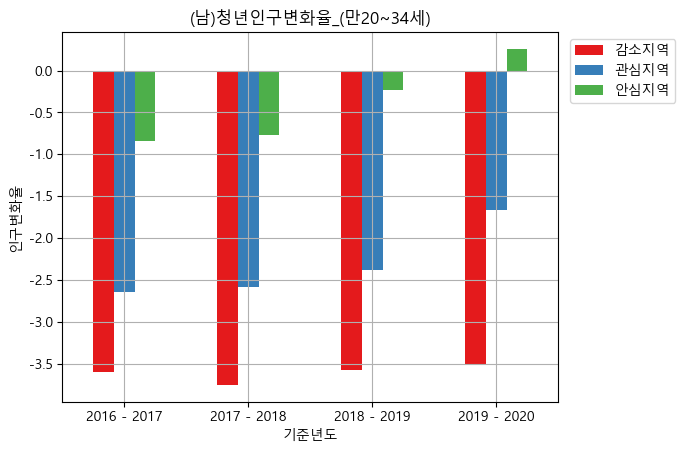

In [707]:
young_pop_var_m.plot(kind="bar",color = sns.set_palette('Set1'))
plt.grid()
plt.title("(남)청년인구변화율_(만20~34세)")
plt.xlabel("기준년도")
plt.ylabel("인구변화율")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.savefig('output/(남)청년인구변화율_(만20~34세).png',bbox_inches="tight")

<AxesSubplot:>

Text(0.5, 1.0, '(여)청년인구변화율_(만20~34세)')

Text(0.5, 0, '기준년도')

Text(0, 0.5, '인구변화율')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2016 - 2017'),
  Text(1, 0, '2017 - 2018'),
  Text(2, 0, '2018 - 2019'),
  Text(3, 0, '2019 - 2020')])

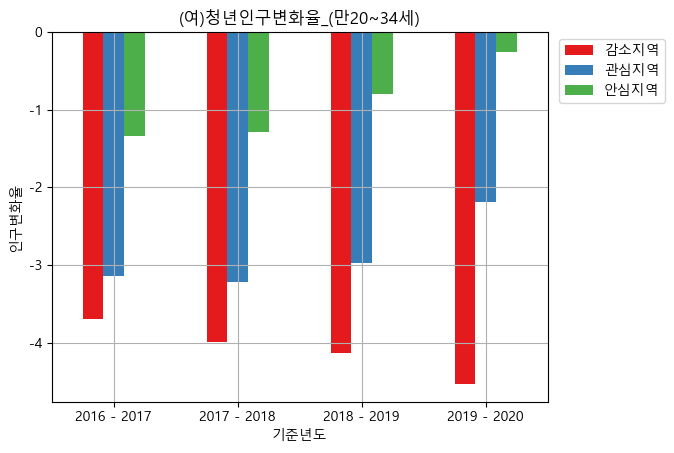

In [708]:
young_pop_var_w.plot(kind="bar",color = sns.set_palette('Set1'))
plt.grid()
plt.title("(여)청년인구변화율_(만20~34세)")
plt.xlabel("기준년도")
plt.ylabel("인구변화율")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.savefig('output/(여)청년인구변화율_(만20~34세).png',bbox_inches="tight")

In [709]:
not_young_pop_var_m = second_age_df([danger_loc_m, att_loc_m,safe_loc_m])
not_young_pop_var_m

,감소지역,관심지역,안심지역
2016 - 2017,-0.330985,-0.062127,1.640461
2017 - 2018,-0.863412,-0.600730,1.282696
2018 - 2019,-1.344946,-1.011648,0.896541
2019 - 2020,-1.958863,-1.381432,0.396013


In [710]:
not_young_pop_var_w = second_age_df([danger_loc_w, att_loc_w,safe_loc_w])
not_young_pop_var_w

,감소지역,관심지역,안심지역
2016 - 2017,-0.793308,-0.236548,1.681125
2017 - 2018,-1.270857,-0.795936,1.273709
2018 - 2019,-1.711497,-1.200569,0.911365
2019 - 2020,-2.360352,-1.600542,0.318247


<AxesSubplot:>

Text(0.5, 1.0, '(남)중년인구변화율_(만35~64세)')

Text(0.5, 0, '기준년도')

Text(0, 0.5, '인구변화율')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2016 - 2017'),
  Text(1, 0, '2017 - 2018'),
  Text(2, 0, '2018 - 2019'),
  Text(3, 0, '2019 - 2020')])

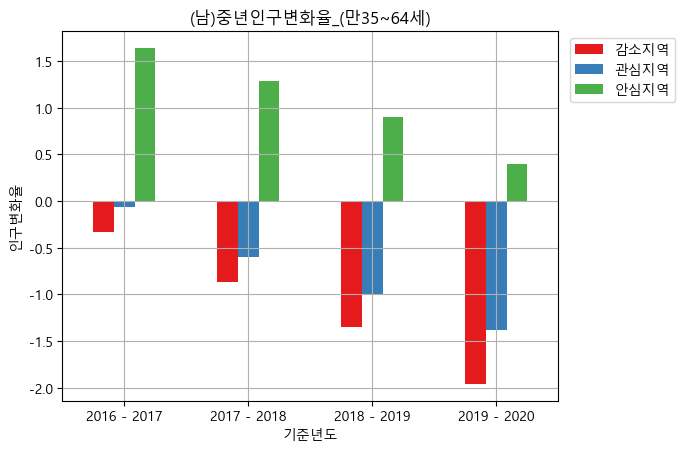

In [711]:
not_young_pop_var_m.plot(kind="bar",color = sns.set_palette('Set1'))
plt.grid()
plt.title("(남)중년인구변화율_(만35~64세)")
plt.xlabel("기준년도")
plt.ylabel("인구변화율")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.savefig('output/(남)중년인구변화율_(만35~64세).png',bbox_inches="tight")

<AxesSubplot:>

Text(0.5, 1.0, '(여)중년인구변화율_(만35~64세)')

Text(0.5, 0, '기준년도')

Text(0, 0.5, '인구변화율')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2016 - 2017'),
  Text(1, 0, '2017 - 2018'),
  Text(2, 0, '2018 - 2019'),
  Text(3, 0, '2019 - 2020')])

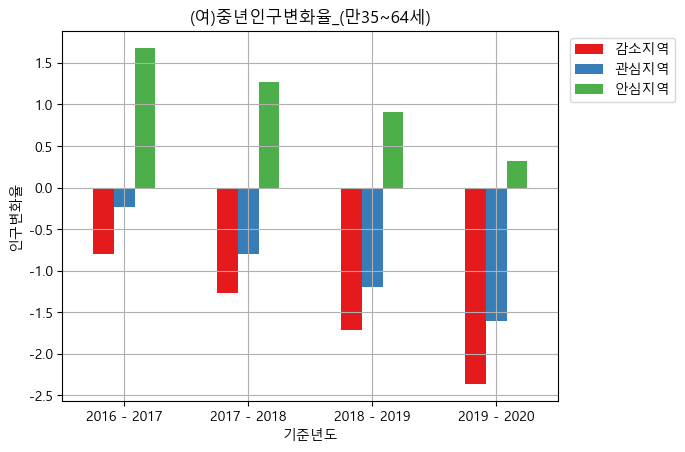

In [712]:
not_young_pop_var_w.plot(kind="bar",color = sns.set_palette('Set1'))
plt.grid()
plt.title("(여)중년인구변화율_(만35~64세)")
plt.xlabel("기준년도")
plt.ylabel("인구변화율")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.savefig('output/(여)중년인구변화율_(만35~64세).png',bbox_inches="tight")